# Saint James Check-outs Analysis

This notebook works with combined data from Saint James Hotel's current monthly booking sheet and the company's archive sheets to analyse check-outs data from the beginning of the year until present (August 2023). The data required a lot of cleaning as it is inputed manually by receptionists working straight out of Microsoft Excel. 

Key takeaways include:  

    1) a price peak in may despite a bookings peak in June/July,  
    2) a bookings peak and Fridays and Saturdays,  
    3) a high turnover of single guest booking staying only 1 night,  
    4) near dominance by Booking.com as a booking provider  

## 1) Data cleaning

### Import data

In [1]:
# import key libraries
import pandas as pd
import numpy as np

# import archive and current sheet data
check_out_df_archive = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/Saint-James-Data-Analysis/Data/check_out_df.xlsx')
check_out_df_current = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/Saint-James-Data-Analysis/Data/current_sheet.xlsx', 'Check-outs')

# make the colnames the same
check_out_df_current.columns = check_out_df_archive.columns

# combine both dataframes
check_out_df = pd.concat([check_out_df_archive, check_out_df_current], axis=0)

# save as a new xlsx file so the columns can be changed to short date format
check_out_df.to_excel('Data/combined_current_archive_df.xlsx')

C:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


### Locate non-blank rows

In [2]:
# reads in the combined check-out dataframe
check_out_df = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/Saint-James-Data-Analysis/Data/combined_current_archive_df.xlsx')

# creates an index object denoting which rows are non-NA and therefore valid rows
col = check_out_df['Check-in']
index = []
for i in range(len(col)):
    try:
        col[i].year
        index.append(i)
    except:
        pass

# resets the check-out dataframe to non-NA rows
check_out_df = check_out_df.iloc[index,:].reset_index(drop=True)

# creates a new dataframe including only non-NA rows for the first 3 columns
clean_check_out_df = pd.DataFrame()
check_out_df = check_out_df[pd.isna(check_out_df.iloc[:,0:3]).sum(axis=1)==0].reset_index(drop=True)

### Separate check-in dates

In [3]:
# imports necessary libraries
import datetime as dt
import statistics as stats

# makes sure no NA values are passed through into the clean dataset
def get_col(df, col_name, dot_method=None):
    col = df[col_name]
    values = []
    for i in range(len(col)):
        try:
            if dot_method != None:
                values.append(eval('df[col_name][i]' + dot_method))
            else:
                values.append(df[col_name][i])
        except:
            pass
    return [i for i in values if pd.isna(i) == False]

# creates seperate columns for the check-in year, month and day
clean_check_out_df['In-Year'] = get_col(check_out_df, 'Check-in', '.year')
clean_check_out_df['In-Month'] = get_col(check_out_df, 'Check-in', '.month')
clean_check_out_df['In-Day'] = get_col(check_out_df, 'Check-in', '.day')

### Separate check-out dates

In [4]:
# creates an NA free nights column to be added to the check-in date to calcuate check-out
nights = get_col(check_out_df, 'Nights')
check_in = get_col(check_out_df, 'Check-in')

# adds nights to check-in to determine check-out
check_out = []
for i in range(len(nights)):
    check_out.append(check_in[i] + dt.timedelta(days = nights[i]))
    
# creates a new dataframe object containing check-outs data
check_out = pd.DataFrame({'check_out': check_out})

# creates 3 seperate columns for the check-outs year, month and day
clean_check_out_df['Out-Year'] = get_col(check_out, 'check_out', '.year')
clean_check_out_df['Out-Month'] = get_col(check_out, 'check_out', '.month')
clean_check_out_df['Out-Day'] = get_col(check_out, 'check_out', '.day')

### View NAs

In [5]:
# creates a cols object for looping
cols = ['Nights', 'Guests', 'room', 'Price', 'Booking Type', 'KD cash', 'KD card', 'payment status', 'Checked status']

# creates a length object for calculating NA percentages
total = len(check_out_df)

# calculates total NAs and NA percentages
NAs = []
percent = []
for i in range(len(cols)):
    NAs.append(sum(check_out_df[cols[i]].isna()))
    percent.append((round(sum(check_out_df[cols[i]].isna()) / total, 3))*100)

# displays NA counts and percentages as a dataframe
pd.DataFrame({'Column': cols, 'NA Count': NAs, 'Percent (%)': percent})

,Column,NA Count,Percent (%)
0,Nights,0,0.0
1,Guests,4,0.1
2,room,3,0.1
3,Price,3,0.1
4,Booking Type,19,0.4
5,KD cash,3163,65.1
6,KD card,2455,50.5
7,payment status,35,0.7
8,Checked status,2931,60.3


### Fill NAs

In [6]:
# assigns the nights object as the nights column
clean_check_out_df['Nights'] = nights

# fills missing guests values with the median
clean_check_out_df['Guests'] = check_out_df['Guests'].fillna(stats.median(check_out_df['Guests']))

# fills missing room values with room 21
clean_check_out_df['Room'] = check_out_df['room'].fillna(21)

# fills missing price values in with the median price
clean_check_out_df['Price'] = check_out_df['Price'].fillna(stats.median(check_out_df['Price']))

# fills missing booking type values with booking vc
clean_check_out_df['Booking Type'] = check_out_df['Booking Type'].str.lower().fillna('Booking VC')

# fills missing kd cash and card values with 0 
clean_check_out_df['KD Cash'] = check_out_df['KD cash'].fillna(0)
clean_check_out_df['KD Card'] = check_out_df['KD card'].fillna(0)

# fills missing payment status values with 'none'
clean_check_out_df['Payment Status'] = check_out_df['payment status'].str.lower().fillna('none')

# creates a binary column where an NA value is assumed to mean the booking was not checked
clean_check_out_df['Booking Checked'] = [1 if i is not True else 0 for i in check_out_df['Checked status'].isna()]

## 2) Transformations

### Transform standard columns

In [7]:
# bookings each month
by_months = clean_check_out_df['In-Month'].value_counts().sort_index().iloc[0:7]

# bookings by number of nights
by_nights = clean_check_out_df['Nights'].value_counts().sort_index().iloc[0:10]

# bookings by number of guests
by_guests = clean_check_out_df['Guests'].value_counts().sort_index().iloc[0:5]

# bookings by individual rooms
by_room = clean_check_out_df['Room'].astype(str).value_counts().sort_index()

# months by total price in thousands
by_price = round(clean_check_out_df.groupby('In-Month').sum()['Price'].iloc[0:7:] / 1000, 1)

### Transform room type

In [8]:
# filters out problematic values
problems = ['03/21', '1900-01-04 00:00:00', '2025-04-01 00:00:00']
index = [True if i not in problems else False for i in by_room.index]
by_room = by_room[index]

# creates lists of rooms for each room type
private = ['A', 'B', 'C', '30', '31', '37']
eight_bed = ['3', '4', '21', '24']
female = ['2', '5', '23']
six_bed = ['36', '32']
four_bed = ['33', '34', '35']
triple = ['1', '6', '20', '25']

# loops through the by room summary and assigns a room type to the room_type object
room_type = []
for  i in range(len(by_room)):
    if by_room.index[i] in private:
        room_type.append('Private')
    elif by_room.index[i] in eight_bed:
        room_type.append('8 bed')
    elif by_room.index[i] in female:
        room_type.append('Female')
    elif by_room.index[i] in six_bed:
        room_type.append('6 bed')
    elif by_room.index[i] in four_bed:
        room_type.append('4 bed')
    elif by_room.index[i] in triple:
        room_type.append('Triple')
    else:
        room_type.append('Multiple')

# creates a dataframe of rooms, counts and types
room_df = pd.DataFrame({'Room': by_room.index, 'Count': by_room, 'Type': room_type}).reset_index(drop=True)

# sorts the data by value count
by_room = room_df.Count.sort_values(ascending=False)
by_room.index = room_df.Room

# sums the data after grouping by room type and reverses the order to be descending
by_room_type = room_df[['Count', 'Type']].groupby('Type').sum().iloc[:,0].sort_values(ascending=True)
by_room_type = by_room_type[::-1]

# calculates the nights booked divided by the number of rooms
beds = [32, 24, 12, 6, 12, 3]
percentages = []
for i in range(len(by_room_type)-1):
    percentages.append(round(by_room_type[i] / beds[i], 1))

# transforms the by_room_type object and takes multiple out of the analysis
by_room_type[0:6] = percentages
by_room_type = by_room_type[0:6]

### Transform booking type

In [9]:
# removes extra whitespace
clean_check_out_df['Booking Type'] = [x.strip() for x in clean_check_out_df['Booking Type']]

# converts mispelled booking vcs 
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'booking', 'Booking Type'] = 'booking vc'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'bookin vc', 'Booking Type'] = 'booking vc'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'bookingvcd', 'Booking Type'] = 'booking vcd'

# converts mispelled expedia vcns 
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'expediavcn', 'Booking Type'] = 'expedia vcn'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'expediavcn', 'Booking Type'] = 'expedia vcn'

# converts group booking to group for concision
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'group booking', 'Booking Type'] = 'group'

# converts trip.com entries into trip for concision
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'trip', 'Booking Type'] = 'trip vc'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'trip.com', 'Booking Type'] = 'trip vc'

# converts mispelled walk-ins 
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walk ', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walk', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'wak-in', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walk in', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walkin', 'Booking Type'] = 'walk-in'

# converts weekly rate to weekly for concision
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'weekly rate', 'Booking Type'] = 'weekly'

# converts to lower, counts values and sorts in descending order
by_booking_type = clean_check_out_df['Booking Type'].str.lower().value_counts().sort_values(ascending=False)

### Transform booking provider

In [10]:
# assigns different booking types to a booking_provider object
booking_provider = []
for i in range(len(clean_check_out_df)):
    if 'ooking' in clean_check_out_df['Booking Type'][i]:
        booking_provider.append('booking')
    elif 'expedia' in clean_check_out_df['Booking Type'][i]:
        booking_provider.append('expedia')
    elif 'trip' in clean_check_out_df['Booking Type'][i]:
        booking_provider.append('trip')
    else:
        booking_provider.append(clean_check_out_df['Booking Type'][i])

# creates a new booking provider column in the clean dataframe
clean_check_out_df['Booking provider'] = booking_provider

# counts different booking provider types and converts the index to title
by_booking_provider = clean_check_out_df['Booking provider'].value_counts().iloc[0:6]
by_booking_provider.index = by_booking_provider.index.str.title()

### Transform key deposit columns

In [11]:
# tests to see if the value in a column is numeric and assigns it 0 if not
def to_numeric_kd_columns(col):
    for i in range(len(col)):
        try:
            col[i] > 0
        except:
            col[i] = 0

# converts both key deposit columns to numeric
to_numeric_kd_columns(clean_check_out_df['KD Cash'])
to_numeric_kd_columns(clean_check_out_df['KD Card'])

# sums cash and card key deposits by month and then calculates a key deposit ratio
by_KD_cash = clean_check_out_df[['In-Month', 'KD Cash']].groupby('In-Month').sum().iloc[0:7].squeeze()
by_KD_card = clean_check_out_df[['In-Month', 'KD Card']].groupby('In-Month').sum().iloc[0:7].squeeze()
by_KD_cash_ratio = (by_KD_cash / (by_KD_cash + by_KD_card))*100

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_1440\2618272433.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = 0


### Transform paid

In [12]:
# lists all the mispellings of paid
paid_mispellings = ['paind', 'paid  ', 'paid by paynow', 'paud ', 'piad', 'paid paynow',
                    'paid with paynow', 'oaid', 'paid  paynow', 'paid   ', 
                    ' paid', 'paidl', 'paynow', 'paif', 'paid by pay now', 'paid ']

# converts all instances of paid mispellings to paid
for i in range(len(clean_check_out_df)):
    if clean_check_out_df['Payment Status'][i] in paid_mispellings:
        clean_check_out_df['Payment Status'][i] = 'paid'

#  creates two binary lists indicating paid or not paid
paid = []
not_paid = []
for i in range(len(clean_check_out_df)):
    if clean_check_out_df['Payment Status'][i] == 'paid':
        paid.append(1)
        not_paid.append(0)
    else:
        paid.append(0)
        not_paid.append(1)

# creates two new binary columns in the dataframe indicating paid and not paid
clean_check_out_df['paid'] = paid
clean_check_out_df['not paid'] = not_paid

# sums paid and not paid by month and then calculates a paid ratio
paid_months = clean_check_out_df[['In-Month', 'paid']].groupby('In-Month').sum().iloc[0:7].squeeze()
not_paid_months = clean_check_out_df[['In-Month', 'not paid']].groupby('In-Month').sum().iloc[0:7].squeeze()
by_payment_mistakes = round((not_paid_months / (paid_months+not_paid_months))*100,2)

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_1440\1244447481.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_check_out_df['Payment Status'][i] = 'paid'


### Transform booking checked

In [13]:
# creates a binary variable with 1 indicating the booking was not checked
clean_check_out_df['Booking not Checked'] = [1 if i is True else 0 for i in check_out_df['Checked status'].isna()]

# creates two list of binary variables indictaing booking checked and not checked
checked = clean_check_out_df[['In-Month', 'Booking Checked']].groupby('In-Month').sum().iloc[0:7].squeeze()
not_checked = clean_check_out_df[['In-Month', 'Booking not Checked']].groupby('In-Month').sum().iloc[0:7].squeeze()

# creates a percentage ratio of bookings checked each month
by_booking_checked = round((checked / (checked+not_checked))*100,2)

### Transform dates to weekdays

In [14]:
# takes in the date and gives back the day of the week
def calculate_day_of_week(year, month, day):
    try:
        # Create a datetime object for the given date
        date_obj = dt.datetime(year, month, day)
        # Get the day of the week as an integer (Monday is 0 and Sunday is 6)
        day_of_week = date_obj.weekday()
        
        return day_of_week
    except ValueError as e:
        return str(e)

# calculates the day of the week for each booking in the dataframe
weekdays = []
for i in range(len(clean_check_out_df)):
    year = clean_check_out_df['In-Year'][i]
    month = clean_check_out_df['In-Month'][i]
    day = clean_check_out_df['In-Day'][i]
    weekdays.append(calculate_day_of_week(year, month, day))
    
# creates a weekdays column
clean_check_out_df['weekday'] = weekdays

# counts weekdays and sorts the index
by_weekday = clean_check_out_df['weekday'].value_counts().sort_index()

## 3) Vizualizations

### Dashboard overview

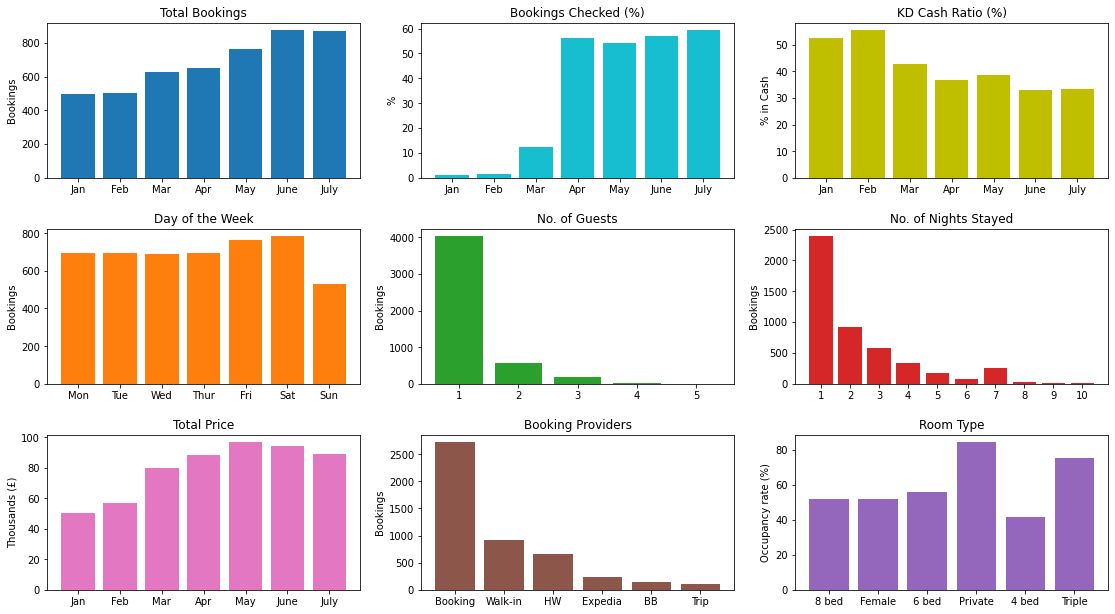

In [15]:
import matplotlib.pyplot as plt 

plots = ['by_months', 'by_nights', 'by_guests', 'by_weekday', 'by_room_type', 'by_booking_provider',
         'by_price', 'by_KD_cash_ratio', 'by_booking_checked']
titles = ['Total Bookings', 'No. of Nights Stayed', 'No. of Guests', 'Day of the Week', 'Room Type', 
          'Booking Providers', 'Total Price', 'KD Cash Ratio (%)', 'Bookings Checked (%)']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July']
days = ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]
providers = ['Booking', 'Walk-in', 'HW', 'Expedia', 'BB', 'Trip']
xticks = [months, None, None, days, None, providers, months, months, months]
ylabs = ['Bookings', 'Bookings', 'Bookings', 'Bookings', 'Occupancy rate (%)', 'Bookings', 'Thousands (£)', '% in Cash', '%']
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'y', 'tab:cyan']

length = len(plots)
cols = 3
rows = int(np.ceil(length / 3))

fig, ax = plt.subplots(rows, cols, figsize=(16,9))
fig.tight_layout(pad=3.0);
for i in range(rows):
    for j in range(cols):
        num = (i*rows)-j
        ax[i, j].bar(eval(plots[num]).index, eval(plots[num]), color=colors[num]);
        ax[i, j].set_title(titles[num]);
        ax[i, j].set_xticks(eval(plots[num]).index, labels=xticks[num]);
        ax[i,j].set_ylabel(ylabs[num]);